Библиотеки для иллюстраций (запуск рендера иллюстраций на локальной машине):

In [9]:
from IPython import display
from base64 import b64decode

In [10]:
from images import scheme_kitaev, scheme_kitaev_2, scheme_SED

# Прототип алгоритма «Solution Existence Detection» (часть 2, тестирование)

Строчка для Google Colab Notebooks:

In [ ]:
!pip install qiskit

Готовая функция для построения схемы алгоритма SED:

In [11]:
import numpy as np

def get_SED_scheme(P_min, N):
    def get_j(k, dir, P_of_0, n, N):
        if dir == 'up':
            return (2*np.pi*(k-1)+np.arccos(2*P_of_0-1))/(2*np.arcsin(np.sqrt(n/N)))
        elif dir == 'down':
            return (2*np.pi*k-np.arccos(2*P_of_0-1))/(2*np.arcsin(np.sqrt(n/N)))
    def get_n(k, dir, j, P_of_0, N):
        if dir == 'up':
            return N*np.sin((2*np.pi*(k-1)+np.arccos(2*P_of_0-1))/(2*j))**2
        elif dir == 'down':
            return N*np.sin((2*np.pi*k-np.arccos(2*P_of_0-1))/(2*j))**2
    js = []
    n = 1
    while True:
        j = int(np.ceil(get_j(k=1, dir='up', P_of_0=1-P_min, N=N, n=n)))
        js.append(j)
        if j == 1:
            break
        n = int(np.floor(get_n(k=1, dir='down', j=j, P_of_0=1-P_min, N=N)))
    return js

scheme = get_SED_scheme(P_min=0.2, N=1024)
scheme

[15, 3, 1]

Утилита для построения графиков:

In [12]:
import plotly.graph_objects as go

def show(data, title="Picture", marker_size=3):
    fig = go.Figure()

    for g in data:

        xy = g[0]
        color = g[1]
        opacity = 1
        if len(g) == 3:
            opacity = g[2]

        fig.add_trace(go.Scatter(
            x=[i[0] for i in xy],
            y=[i[1] for i in xy],
            mode='markers',
            marker_color=color,
            opacity=opacity
        ))

    fig.update_traces(mode='markers', marker_size=marker_size)
    fig.update_layout(title=title, yaxis_zeroline=False, xaxis_zeroline=False)

    fig.show()

Библиотеки:

In [13]:
from qiskit import Aer, execute
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit.providers.aer.extensions.snapshot_probabilities import *
from qiskit.tools.visualization import plot_histogram

Утилиты для алгоритма усиления амплитуды (Гровера):

In [14]:
def diffusion_constructor(n):

    assert n > 1, 'Argument n should be > 1.'
    
    qubits = QuantumRegister(n)
    circuit = QuantumCircuit(qubits)

    circuit.h(qubits)
    circuit.x(qubits)
    circuit.h(qubits[-1])
    
    length = len(qubits)
    
    if length > 3:
        circuit.mcx(qubits[0:-1], qubits[-1])
    elif length == 3:
        circuit.toffoli(*qubits[0:-1], qubits[2])
    elif length == 2:
        circuit.cx(qubits[0], qubits[1])
    
    circuit.h(qubits[-1])
    circuit.x(qubits)
    circuit.h(qubits)

    return circuit

Тестовый оракул, генерирует $n$ «хороших» комбинаций:

In [15]:
def test_oracle_constructor(extra_arguments, inverted=False):

    '''Requires q qubits:
    - q — input qubits prepared with H gates'''

    # n — number of good answers
    # q — number of qubits
    
    n, q = extra_arguments
    
    qubits = QuantumRegister(q)
    circuit = QuantumCircuit(qubits)

    array = []
    x_close = []

    def crt(circuit, q_reg, n, array):
        q = len(q_reg)
        if n == 0:
            return array
        if n == 1:
            for e in q_reg:
                array.append(e)
            return array
        lim = 2 ** (q - 1)
        if n <= lim:
            array.append(q_reg[0])    
            n = n % lim
            array = crt(circuit, q_reg[1:], n, array)
        else:
            array.append(q_reg[0])
            circuit.h(array[-1])
            if len(array) > 1:
                circuit.mcx(array[0:-1], array[-1])
            else:
                circuit.x(array[0])
            circuit.h(array[-1])
            circuit.x(q_reg[0])
            x_close.append(q_reg[0])
            n = n % lim
            array = crt(circuit, q_reg[1:], n, array)
        return array

    array = crt(circuit, qubits, n, array)

    if len(array) == 1:
        circuit.h(array[0])
        circuit.x(array[0])
        circuit.h(array[0])
    elif len(array) > 1:
        circuit.h(array[-1])
        circuit.mcx(array[0:-1], array[-1])
        circuit.h(array[-1])

    if len(x_close) > 0:
        circuit.x(x_close)

    return circuit

# Локальный симулятор (4 кубита)

In [16]:
q = 4
N = 2 ** q
N

16

In [17]:
P_min = 0.2

In [18]:
scheme = get_SED_scheme(P_min=P_min, N=N)
scheme

[2, 1]

Общее число итераций:

In [19]:
sum(scheme)

3

Число дополнительных кубит:

In [20]:
len(scheme) + 1

3

In [21]:
def get_P_of_0(j, n, N):
    return (1 + np.cos(2 * j * np.arcsin(np.sqrt(n / N)))) / 2

def get_P_of_0_complex(js, n, N):
    p = 1
    for j in js:
        p *= get_P_of_0(j, n, N)
    return 1 - p

In [22]:
rlts = []

for j in scheme:

    C = []
    for n in [0, 1, *list(range(1, N, 1)), N]:
        p = get_P_of_0_complex([j], n, N)
        C.append((n, p))

    rlts.append(C)

C = []

for n in [0, 1, *list(range(1, N, 1)), N]:
    p = get_P_of_0_complex(scheme, n, N)
    C.append((n, p))

rlts.append(C)

datasets = [[[(x[0], x[1]) for x in C], 'blue', 0.5] for C in rlts]
datasets[-1][1] = 'red'
datasets[-1][2] = 1

show(datasets, marker_size=5)

## Cхема

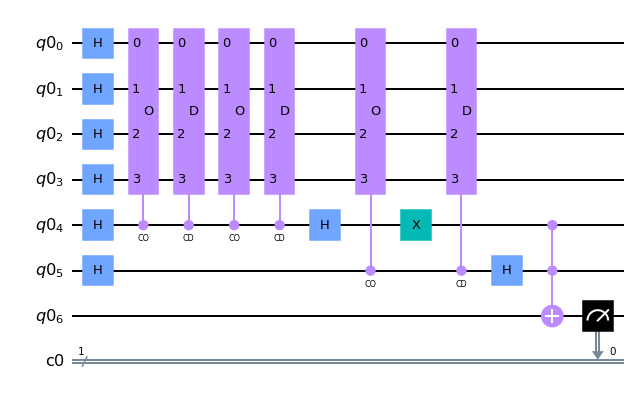

In [23]:
n = 3

qr = QuantumRegister(q + len(scheme) + 1)
cr = ClassicalRegister(1)
qc = QuantumCircuit(qr, cr)

input = qr[0:q]
rs = qr[q:-1]
result = qr[-1]

to_measure = [result]

qc.h(rs)
qc.h(input)

for i, s in enumerate(scheme):

    oracle = test_oracle_constructor(extra_arguments = (n, q)).\
                to_gate()
    oracle.label = 'O'
    c_oracle = oracle.control()
    c_oracle.label = 'CO'

    diffusion = diffusion_constructor(q).to_gate()
    diffusion.label = 'D'
    c_diffusion = diffusion.control()
    c_diffusion.label = 'CD'

    for _ in range(s):
        qc.append(c_oracle, [rs[i], *input])
        qc.append(c_diffusion, [rs[i], *input])

    qc.h(rs[i])
    
    if s % 2 == 0:
        qc.x(rs[i])

qc.mcx(rs, result)

qc.measure(to_measure,cr)
qc.draw('mpl')

{'1': 2579, '0': 5613}


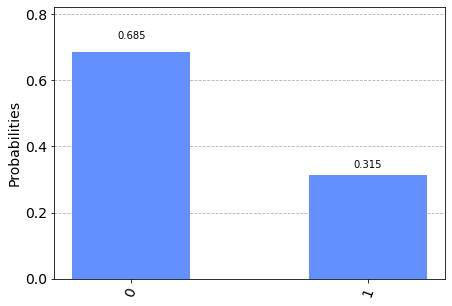

In [24]:
shots = 8192
simulator = Aer.get_backend('aer_simulator')
result = execute(qc, backend = simulator, shots = shots).result()
counts = result.get_counts()

print(counts)
plot_histogram(counts)

# Квантовый компьютер (4 кубита)

In [20]:
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor

In [21]:
token = '...'

In [22]:
IBMQ.save_account(token, overwrite=True)
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [23]:
provider = IBMQ.get_provider(hub='ibm-q')

In [25]:
device = provider.get_backend('ibm_nairobi')
job = execute(qc, backend=device, shots=8192)

job_monitor(job)

device_result = job.result()
device_counts = device_result.get_counts()

Job Status: job has successfully run


{'0': 6466, '1': 1726}


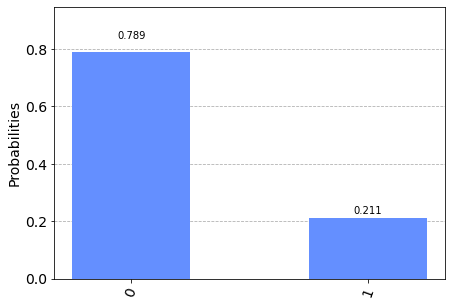

In [26]:
print(device_counts)
plot_histogram(device_counts)

In [ ]:
shots = 8192
simulator = Aer.get_backend('aer_simulator')
result = execute(qc, backend = simulator, shots = shots).result()
counts = result.get_counts()

print(counts)
plot_histogram(counts)

На реальном квантовом компьютере очень большая ошибка!

# Удаленный симулятор IBM (10 кубит)

In [25]:
q = 10
N = 2 ** q
N

1024

In [26]:
P_min = 0.2

In [27]:
scheme = get_SED_scheme(P_min=P_min, N=N)
scheme

[15, 3, 1]

In [28]:
sum(scheme)

19

In [29]:
len(scheme) + 1

4

In [30]:
limit = 1000
step = int(N / limit)

rlts = []

for j in scheme:

    combo = []
    for n in [0, 1, *list(range(1, N, step)), N]:
        p = get_P_of_0_complex([j], n, N)
        combo.append((n, p))

    rlts.append(combo)

combo = []

for n in [0, 1, *list(range(1, N, step)), N]:
    p = get_P_of_0_complex(scheme, n, N)
    combo.append((n, p))

rlts.append(combo)

datasets = [[[(x[0], x[1]) for x in combo], 'blue', 0.5] for combo in rlts]
datasets[-1][1] = 'red'
datasets[-1][2] = 1

show(datasets, marker_size=2)

In [33]:
n = 2

qr = QuantumRegister(q + len(scheme) + 1)
cr = ClassicalRegister(1)
qc = QuantumCircuit(qr, cr)

input = qr[0:q]
rs = qr[q:-1]
result = qr[-1]

to_measure = [result]

qc.h(rs)
qc.h(input)

oracle = test_oracle_constructor(extra_arguments = (n, q)).to_gate()
oracle.label = 'O'
c_oracle = oracle.control()
c_oracle.label = 'CO'

diffusion = diffusion_constructor(q).to_gate()
diffusion.label = 'D'
c_diffusion = diffusion.control()
c_diffusion.label = 'CD'

for i, s in enumerate(scheme):
    
    for _ in range(s):
        qc.append(c_oracle, [rs[i], *input])
        qc.append(c_diffusion, [rs[i], *input])

    qc.h(rs[i])
    
    if s % 2 == 0:
        qc.x(rs[i])

qc.mcx(rs, result)
qc.measure(to_measure,cr)

In [34]:
provider = IBMQ.get_provider(hub='ibm-q')
device = provider.get_backend('ibmq_qasm_simulator')
job = execute(qc, backend=device, shots=8192)

job_monitor(job)

device_result = job.result()
device_counts = device_result.get_counts()

Job Status: job has successfully run


{'0': 3189, '1': 5003}


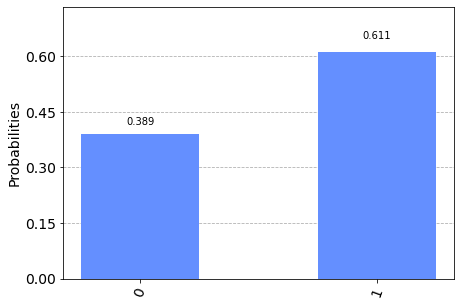

In [35]:
print(device_counts)
plot_histogram(device_counts)

Значение приблизительно равно ожидаемому $\approx 0.39$ для 2-х решений согласно графику выше.